In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
import napari


from skimage import filters, morphology, segmentation, feature, measure
from skimage.util import compare_images
from skimage.io import imread, imsave
import scipy.ndimage as ndi

import h5py   # HDF5 data file management library
from glob import glob
from tqdm.notebook import tqdm

In [2]:
def save_h5(data, path, name):
  filename = path+name+'.h5'
  print('Saving '+filename)
  hf = h5py.File(filename, 'a')
  hf= hf.create_dataset(name, data=data)
  
def load_h5(path, name):
  filename = path+name+'.h5'
  print('\nLoading '+filename)
  hf = h5py.File(filename, 'r').get(name)
  print('Converting to array')
  return np.array(hf)

In [3]:
def plot_comparison(input_img, output_img, cmap = ['gray', 'inferno'],
                    labels=['input_data', 'output_data'], frame=None, merge=False, axes=None):
  title_size = 20
  
  if merge:
    if axes is None:
      fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
    if frame is not None:
      axes[2].set_title('merge[%i]'%frame, size=title_size)
    else:
      axes[2].set_title('merge', size=title_size)
    axes[2].imshow(input_img, cmap=cmap[0])
    axes[2].imshow(output_img, cmap=cmap[1], alpha=0.5)
    axes[2].set(xticks=[], yticks=[])
    axes[2].axis('off')
  
  else:
    if axes is None:
      fig, axes = plt.subplots(1, 2, figsize=(5*2, 5))
  
  for ax, img, c, title in zip(axes[:2], [input_img, output_img], 
                               cmap, labels[:2]):
    if frame is not None:
      ax.set_title(title+'[%i]'%frame, size=title_size)
    else:
      ax.set_title(title, size=title_size)
    ax.imshow(img, cmap=c)
    ax.axis('off')
  
  plt.subplots_adjust(wspace=0.05)
  return axes

In [4]:
def distance_watershed(img):
  distance = ndi.distance_transform_edt(img)
  coords = feature.peak_local_max(distance, labels=img>0)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = ndi.label(mask)[0]
  return segmentation.watershed(-distance, markers, mask=img)

def prepareProc(img, threshold=0, vmax=255):
  labels = distance_watershed(img)  
  labels = segmentation.clear_border(labels)
  img2 = np.zeros_like(img)
  if len(np.unique(labels))>1: #Pixels above the threshold and not in contact with the border
    # Gaussian dilation to increase minimal spot size
    rp = measure.regionprops(labels)
    centroids = np.array([region.centroid for region in rp]).round().astype(int)
    mask = (centroids[:, 0], centroids[:, 1])
    img2[mask] = img[mask]
    img2 = filters.gaussian(img2, 2)
    img2 = img2*vmax/img2.max()
  return img2

def prepareStack(stack, **kwargs):
  if stack.ndim == 2:
    return prepareProc(stack, **kwargs)
  procStack = np.zeros_like(stack)
  for i, img in tqdm(enumerate(stack)):
    procStack[i] = prepareProc(img, **kwargs)
  return procStack

In [21]:
data_path = 'Y:/Model/' 
new_data_path = data_path+'Santi/'

#Inputs
input_data = load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

#proc_output_data = load_h5(new_data_path, 'GaussProc')
#print('Processed outputs:', proc_output_data.shape)


Loading Y:/Model/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading Y:/Model/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [16]:
proc_output_data = load_h5(new_data_path, 'WatProc')


Loading Y:/Model/Santi/WatProc.h5
Converting to array


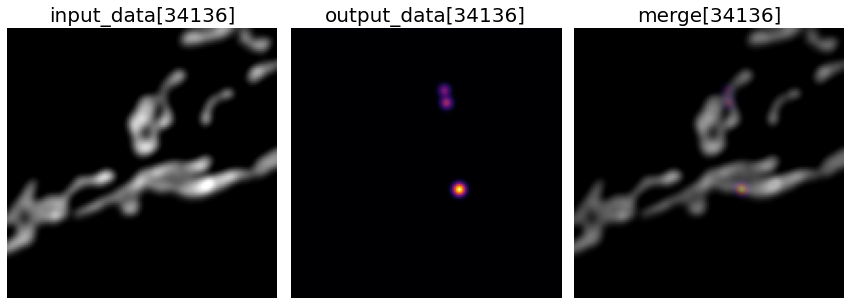

In [23]:
nb_examples = 2
#item_id = np.random.randint(low=0, high=output_data.shape[0]-1, size=nb_examples)
item_id = [34136]
for input_img, output_img, frame in zip(input_data[item_id], proc_output_data[item_id], item_id):
  plot_comparison(input_img, output_img, frame=frame, merge=True)

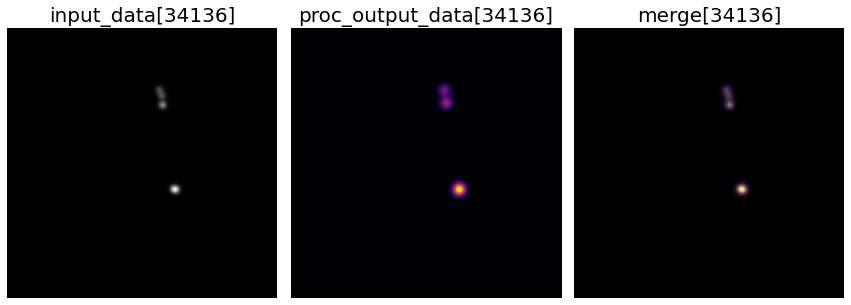

In [10]:
labels = ['input_data', 'proc_output_data']
for input_img, output_img, frame in zip(output_data[item_id], output_data[item_id], item_id):
  plot_comparison(input_img, prepareStack(output_img), labels=labels, frame=frame, merge=True)

In [118]:
nb_examples = 2
#item_id = np.random.randint(low=0, high=output_data.shape[0]-1, size=nb_examples)

blending = 'additive'
opacity = 0.7

cmap = {'input_data': 'gray', 'output_data': 'red', 'proc_output_data': 'inferno'}
gamma_output = 0.2

viewer = napari.Viewer()
viewer.add_image(input_data[item_id], colormap=cmap['input_data'], 
                 blending=blending, opacity=opacity, name='Mito')
viewer.add_image(output_data[item_id], colormap=cmap['output_data'], 
                 blending=blending, gamma=gamma_output, name='Output')
viewer.add_image(proc_output_data[item_id], colormap=cmap['proc_output_data'], 
                 blending=blending, gamma=gamma_output, name='Proc. output')
viewer.add_image(prepareStack(output_data[item_id]), colormap=cmap['proc_output_data'], 
                 blending=blending, gamma=gamma_output, name='Proc. output2')

0it [00:00, ?it/s]

<Image layer 'Proc. output2' at 0x20822333f70>

In [299]:
blending = 'additive'
opacity = 0.7

cmap = {'input_data': 'gray', 'output_data': 'red', 'proc_output_data': 'inferno'}
gamma_output = 0.2

viewer = napari.Viewer()
viewer.add_image(input_data, colormap=cmap['input_data'], 
                 blending=blending, opacity=opacity, name='Mito')
#viewer.add_image(output_data, colormap=cmap['output_data'], 
#                 blending=blending, gamma=gamma_output, name='Output')
viewer.add_image(proc_output_data, colormap=cmap['proc_output_data'], 
                 blending=blending, gamma=gamma_output, name='Proc. output')

<Image layer 'Proc. output' at 0x1aaa60061f0>

In [100]:
#Check how many yes/no images there are.
division_mask = proc_output_data!=0
binary_output_data = (np.any(np.any(division_mask, axis=1), axis=1))

In [101]:
nb_img = input_data.shape[0]
yes_counts = np.sum(binary_output_data)
no_counts = nb_img-yes_counts
print('Yes: ', yes_counts)
print('No: ', no_counts)
print('Yes/No ratio: ', yes_counts/no_counts)

Yes:  24004
No:  12996
Yes/No ratio:  1.8470298553401046


(24004,)

In [268]:
mean_output_data = np.zeros(nb_img)
max_output_data = np.zeros(nb_img)
for frame in tqdm(np.where(binary_output_data)[0]):
  mean_output_data[frame] = np.mean(proc_output_data[frame])
  max_output_data[frame] = np.max(proc_output_data[frame])


  0%|          | 0/24004 [00:00<?, ?it/s]

(array([1.2996e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 6.4000e+01, 1.2621e+04, 2.2440e+03, 1.3500e+03,
        1.1730e+03, 9.0300e+02, 8.6100e+02, 9.7900e+02, 8.0900e+02,
        1.0880e+03, 4.2500e+02, 3.0800e+02, 2.4100e+02, 2.2400e+02,
        1.4300e+02, 9.0000e+01, 7.8000e+01, 6.7000e+01, 6.9000e+01,
        7.3000e+01, 4.8000e+01, 3.9000e+01, 2.4000e+01, 1.4000e+01,
        2.2000e+01, 1.4000e+01, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        7.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.04831299, 0.09662598, 0.14493896, 0.19325195,
        0.24156494, 0.28987793, 0.33819092, 0.38650391, 0.43481689,
        0.48312988, 0.53144287, 0.57975586, 0.62806885, 0.67638184,
        0.72469482, 0.77300781, 0.8213208 , 0.86963379, 0.91794678,
        0.96625977, 1.01457275, 1.06288574, 1.

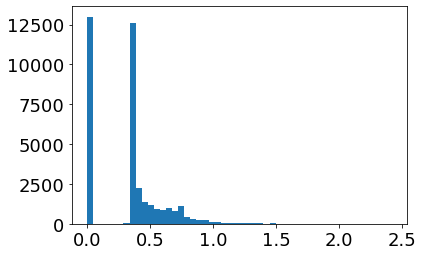

In [310]:
plt.hist(mean_output_data, bins=50)

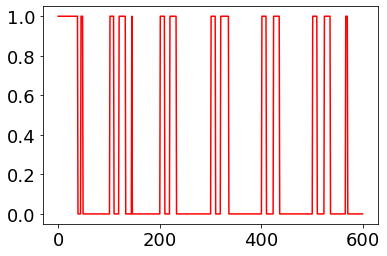

In [311]:
#plt.plot(mean_output_data[:400], '-', color='blue')
plt.plot(ndi.median_filter(mean_output_data[:600], size=5)>0.5, '-', color='red')

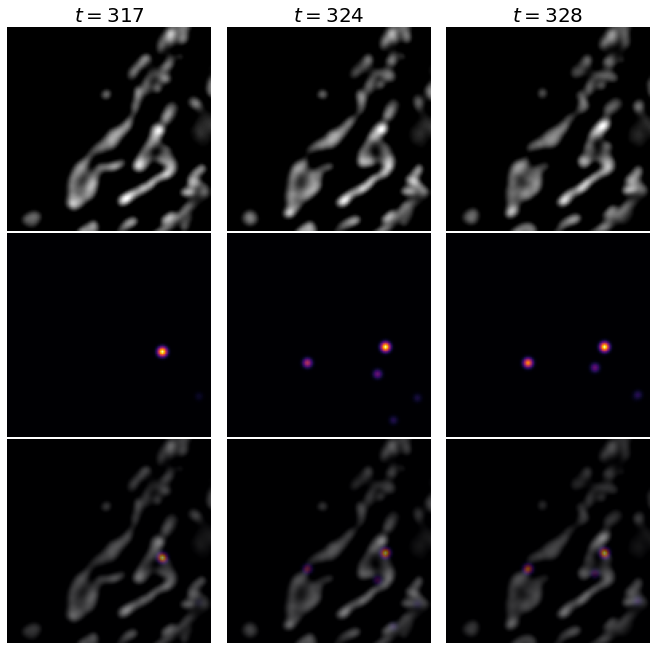

In [263]:
nb_examples = 3
item_id = [317, 324, 328]
size = nb_examples*3
fig, axes = plt.subplots(nb_examples, nb_examples, figsize=(size, size))
for i, frame in enumerate(item_id):
  plot_comparison(input_data[frame], proc_output_data[frame], merge=True, axes=axes[:, i])
  axes[0, i].set_title('$t=%i$'%frame, size=20)
  axes[1, i].set_title('')
  axes[2, i].set_title('')

fig.subplots_adjust(left=0, right=1, top=0.96, bottom=0.01, wspace=0.05, hspace=0.01)
#plt.show()
fig.savefig(new_data_path+'division_example.pdf')